<a href="https://colab.research.google.com/github/avarlotta/time-series-forecasting/blob/main/subcat_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from google.colab import auth, drive
from google.cloud import bigquery
from prophet import Prophet

In [ ]:
client = bigquery.Client(project='prism-insights')
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = Path() / 'drive/My Drive/Colab Notebooks'

In [ ]:
sales_query = '''WITH sales AS (
      SELECT date,
             item_sub_category,
             SUM(items_sold) AS num_sales
      FROM `prism-insights.prism_insights_production.stock_forecast_sub_categories`
      GROUP BY 2, 1
      ORDER BY 1)
SELECT *
FROM sales
'''

sales_df = client.query(sales_query).to_dataframe()

In [ ]:
sales_df.head()

,date,item_sub_category,num_sales
0,2020-01-01,Belts,12
1,2020-01-01,Socks,99
2,2020-01-01,Scarves & Winter Hats & Gloves,24
3,2020-01-01,Home & Decoration,69
4,2020-01-01,Undershirts,3


In [ ]:
stock_query = '''WITH sales AS (
      SELECT item_sub_category,
             average_of_item_price,
             average_of_item_cost,
             discount_price,
             cost_of_overage,
             cost_of_underage,
             (cost_of_overage - cost_of_underage) AS difference
      FROM `prism-insights.prism_insights_production.stock_forecast_purchases`
      ORDER BY difference DESC)
SELECT *
FROM sales
'''

stock_df = client.query(stock_query).to_dataframe()

In [ ]:
stock_df.head()

,item_sub_category,average_of_item_price,average_of_item_cost,discount_price,cost_of_overage,cost_of_underage,difference
0,Watches,163.32,96.98,14.34,102.22,61.10,41.12
1,Electronics,163.09,96.32,78.40,101.56,61.53,40.03
2,Eyewear,65.18,41.54,14.64,46.78,18.40,28.38
3,Bags,46.74,24.99,12.43,30.23,16.51,13.72
4,Sports Equipment,12.29,7.46,0.72,12.70,-0.41,13.11


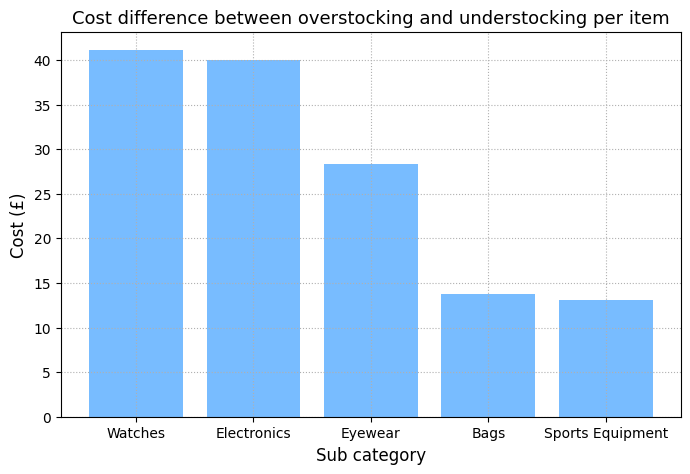

In [ ]:
fig, axes = plt.subplots(figsize=(8, 5))
columns = ['Sub-category item', 'Mean item price', 'Mean item cost', 'Overage cost', 'Underage cost', 'Overage - Underage']
axes.bar(stock_df['item_sub_category'][:5], stock_df['difference'][:5], alpha=0.6, color='dodgerblue')
plt.grid(True, linestyle=':')
axes.set_xlabel('Sub category', fontsize=12)
axes.set_ylabel('Cost (£)', fontsize=12)
axes.set_title('Cost difference between overstocking and understocking per item', fontsize=13);

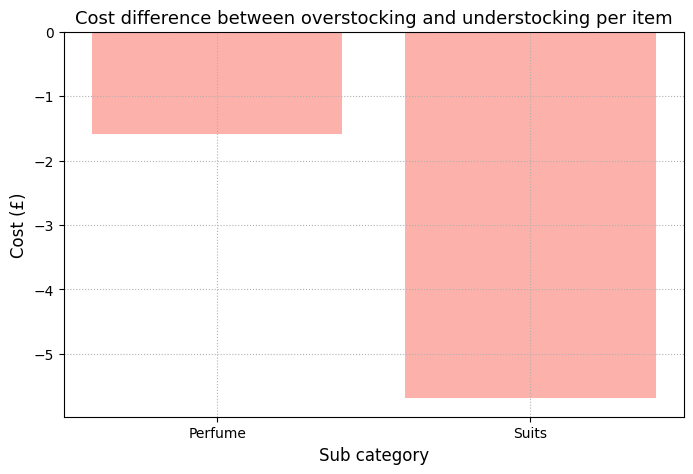

In [ ]:
fig, axes = plt.subplots(figsize=(8, 5))
columns = ['Sub-category item', 'Mean item price', 'Mean item cost', 'Overage cost', 'Underage cost', 'Overage - Underage']
axes.bar(stock_df['item_sub_category'][-2:], stock_df['difference'][-2:], alpha=0.6, color='salmon')
plt.grid(True, linestyle=':')
axes.set_xlabel('Sub category', fontsize=12)
axes.set_ylabel('Cost (£)', fontsize=12)
axes.set_title('Cost difference between overstocking and understocking per item', fontsize=13);

In [ ]:
def sub_category_group(sub_cat):
  df = sales_df.groupby(['date', 'item_sub_category']).sum()
  df.reset_index(['date', 'item_sub_category'], inplace=True)
  df = df[df['item_sub_category'] == sub_cat][['date', 'num_sales']]
  df = df.rename(columns={'date': 'ds', 'num_sales': 'y'})
  df.reset_index(drop='index', inplace=True)
  return df

In [ ]:
electronics_df = sub_category_group('Electronics')
eyewear_df = sub_category_group('Eyewear')

In [ ]:
def remove_outliers(df, uq):
  df['y'] = df['y'].astype(float)
  Q1 = df['y'].quantile(1 - uq)
  Q3 = df['y'].quantile(uq)
  print(f'Q1: {Q1}, Q3: {Q3}')
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  print(f'lower_bound: {lower_bound}, upper_bound: {upper_bound}')
  df['y'] = df['y'].clip(lower_bound, upper_bound)
  return df

In [ ]:
eyewear_clipped_df = remove_outliers(eyewear_df, 0.775)

Q1: 3.0, Q3: 9.0
lower_bound: -6.0, upper_bound: 18.0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ryn3q7o/_vd3snl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ryn3q7o/48f262wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14498', 'data', 'file=/tmp/tmp6ryn3q7o/_vd3snl2.json', 'init=/tmp/tmp6ryn3q7o/48f262wt.json', 'output', 'file=/tmp/tmp6ryn3q7o/prophet_modely888528f/prophet_model-20231215112148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


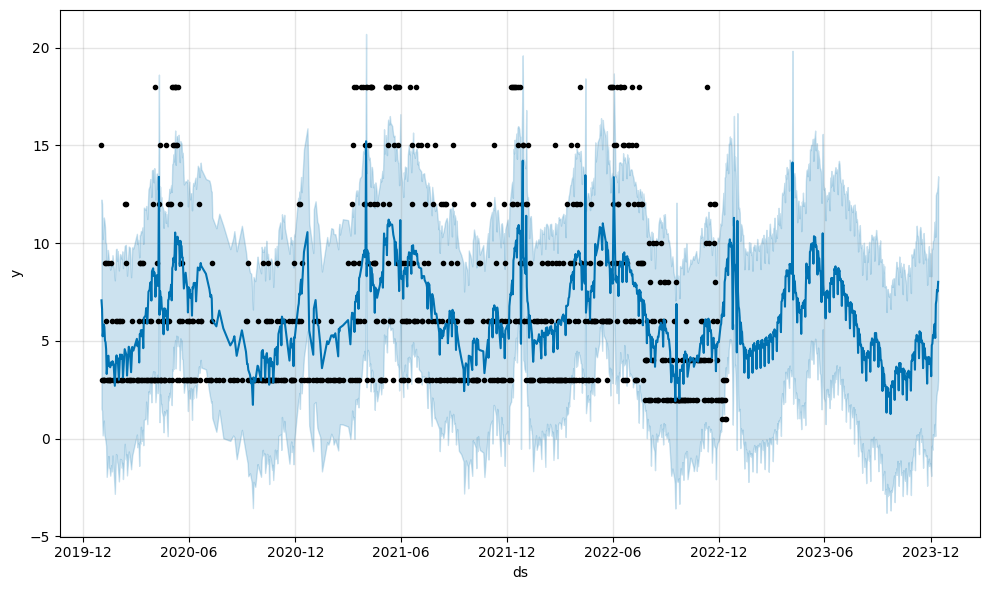

In [ ]:
# Initialize Prophet model
m = Prophet()

# Add country holidays (if applicable)
m.add_country_holidays(country_name='UK')

# Fit the model
m.fit(eyewear_clipped_df)

# Create future dataframe
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Compare forecast to actual values in validation set
# You can use plots or metrics like MAE, RMSE, etc.

# Visualize forecast
fig1 = m.plot(forecast)

In [ ]:
def forecast_resampling(df, date_lower):
  df = forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].set_index('ds').loc[date_lower:]
  weekly_forecast_df = df.resample('W').mean()
  monthly_forecast_df = df.resample('M').mean()
  return weekly_forecast_df, monthly_forecast_df

In [ ]:
weekly_forecast_eyewear_df, monthly_forecast_eyewear_df = forecast_resampling(forecast, '2022-12-12')

In [ ]:
weekly_forecast_eyewear_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-18,3.668146,8.867519,14.095590
2022-12-25,4.056620,9.163152,14.364757
2023-01-01,2.991806,8.256647,13.527625
2023-01-08,1.872842,7.001123,12.236488
2023-01-15,-0.189878,4.753336,10.066443


In [ ]:
monthly_forecast_eyewear_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-31,3.779958,8.980034,14.203981
2023-01-31,-0.093266,5.018625,10.278497
2023-02-28,-0.517551,4.726097,9.911148
2023-03-31,1.308425,6.444836,11.702913
2023-04-30,2.327995,7.531577,12.744994


In [ ]:
monthly_forecast_eyewear_df.tail()

,yhat_lower,yhat,yhat_upper
ds,,,
2023-08-31,-0.702055,4.541652,9.762288
2023-09-30,-2.163988,3.023846,8.213258
2023-10-31,-1.785686,3.351610,8.515710
2023-11-30,-0.616206,4.504426,9.688725
2023-12-31,0.638859,5.797018,10.961504


In [ ]:
def historical_resampling(df):
  df['ds'] = pd.to_datetime(df['ds'])
  historical_df = df.set_index('ds')
  weekly_historical_df = historical_df.resample('W').mean()
  monthly_historical_df = historical_df.resample('M').mean()
  return weekly_historical_df, monthly_historical_df

In [ ]:
weekly_historical_eyewear_df, monthly_historical_eyewear_df = historical_resampling(eyewear_df)

In [ ]:
weekly_historical_eyewear_df.shape

(155, 1)

In [ ]:
weekly_historical_eyewear_no_na_df = weekly_historical_eyewear_df[weekly_historical_eyewear_df.y.notnull()]

In [ ]:
weekly_historical_eyewear_no_na_df.shape

(151, 1)

In [ ]:
monthly_historical_eyewear_df.shape

(36, 1)

In [ ]:
monthly_historical_eyewear_df[monthly_historical_eyewear_df.y.notnull()].shape

(36, 1)

In [ ]:
def plot_forecast(df, f_df, title):

  fig, axes = plt.subplots(figsize=(10, 6))
  data_obj = {'x': df.index,
              'yhat': df.y,}

  forecast_obj = {'x': f_df.index,
                  'yhat': f_df.yhat,
                  'yhat_lower': f_df.yhat_lower,
                  'yhat_upper': f_df.yhat_upper}

  # historical data
  axes.plot('x', 'yhat', color='black', data=data_obj, label='Mean')

  # connecting data
  axes.plot([data_obj['x'][-1], forecast_obj['x'][0]],
            [data_obj['yhat'][-1], forecast_obj['yhat'][0]],
            color='black')

  # forecast data
  axes.fill_between(forecast_obj['x'], forecast_obj['yhat'], forecast_obj['yhat_upper'], color='mistyrose')
  axes.fill_between(forecast_obj['x'], forecast_obj['yhat'], forecast_obj['yhat_lower'], color='lightpink')
  axes.plot('x', 'yhat_lower', color='gray', data=forecast_obj, linestyle=':', label='95% lower CI')
  axes.plot('x', 'yhat_upper', color='gray', data=forecast_obj, linestyle='-.', label='95% upper CI')
  axes.legend(loc='best')
  axes.plot('x', 'yhat', color='black', data=forecast_obj)

  axes.set_xlabel(title.title(), fontsize=12)
  axes.set_ylabel('Total number items sold', fontsize=12)
  axes.set_title('Monthly average number of sales in '+title, fontsize=14)
  plt.grid(True, linestyle=':')
  plt.show()

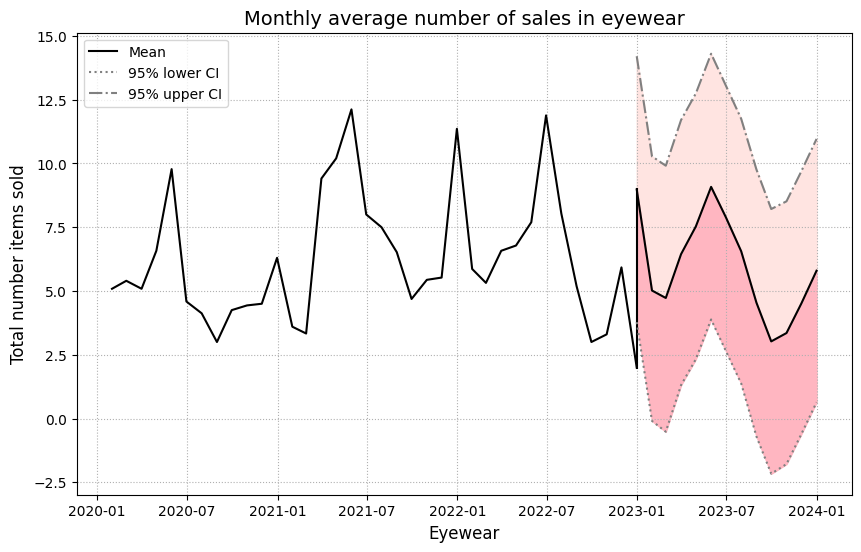

In [ ]:
plot_forecast(monthly_historical_eyewear_df, monthly_forecast_eyewear_df, 'eyewear')